# Analysis of Prosper Loans data

## Investigation Overview

In this investigation I wanted to find out what characteristics an "average" borrower of Prosper Loans has and what variables of the data set affect the loan amount and the APR the most.

## Dataset Overview

After the cleaning the data consisted of 106,159 loan records in the dataset with 17 features including the loan category, the Prosper score, the credit score, the occupation, the employment status and other.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [9]:
loans = pd.read_csv('prosperLoanData.csv')

In [10]:
# creating a subset of data with selected attributes
loans = loans[['ListingKey', 'ListingCreationDate', 'Term', 'LoanStatus',
       'BorrowerAPR', 'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState', 'Occupation', 
       'EmploymentStatus', 'IsBorrowerHomeowner', 'CreditScoreRangeLower','TotalCreditLinespast7years',
       'TotalInquiries', 'CurrentDelinquencies','StatedMonthlyIncome', 
       'LoanOriginalAmount']]

In [11]:
%%capture
# replace na with 0 to indicate that there's no data for the ProsperScore
loans.ProsperScore.fillna(0,inplace=True)
# drop na since I can't restore the missing data and it's relatively small part of all dataset
loans.dropna(inplace=True)

In [12]:
%%capture
loans.rename(columns = {'ListingKey':'Key','ListingCreationDate':'Date','LoanStatus':'Status',
                        'ListingCategory (numeric)':'Category',
                        'BorrowerAPR':'APR','BorrowerState':'State', 'IsBorrowerHomeowner':'Homeowner',
                        'CreditScoreRangeLower': 'CreditScore', 'TotalCreditLinespast7years':'CreditLines',
                        'StatedMonthlyIncome':'Income', 'LoanOriginalAmount':'Amount',
                        'TotalInquiries':'Inquiries','CurrentDelinquencies':'Delinquencies'},inplace = True)

In [13]:
replace_stat = {'Past Due (1-15 days)': 'Past Due 1-120 days', 'Past Due (16-30 days)': 'Past Due 1-120 days', 
                'Past Due (31-60 days)': 'Past Due 1-120 days', 'Past Due (61-90 days)': 'Past Due 1-120 days',
               'Past Due (91-120 days)':'Past Due 1-120 days'}
loans.Status = loans.Status.replace(replace_stat)

In [14]:
loans.drop(loans.query('Status in ["FinalPaymentInProgress","Past Due (>120 days)","Cancelled"]').index,inplace=True)

In [15]:
replace_cat = {0: 'Not Available', 1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business', 
               4: 'Personal Loan', 5: 'Student Use', 6: 'Auto', 7: 'Other', 8:'Baby&Adoption', 
               9: 'Boat', 10: 'Cosmetic Procedure', 11: 'Engagement Ring', 12: 'Green Loans', 
               13: 'Household Expenses', 14: 'Large Purchases', 15: 'Medical/Dental', 16: 'Motorcycle',
               17: 'RV', 18: 'Taxes', 19: 'Vacation', 20: 'Wedding Loans'}
loans.Category = loans.Category.replace(replace_cat)

In [16]:
loans.Homeowner = loans.Homeowner.replace({True:'Homeowner',False:'Not a homeowner'})

In [17]:
for i in ['CreditScore','CreditLines','Inquiries','Delinquencies','ProsperScore']:
    loans[i] = loans[i].astype(int)

In [18]:
# convert cut, color, and clarity into ordered categorical types
# NOTE: the ProsperScore values should be ranked 1-10 but 11 score is also present. I decided not to delete them.
ordinal_var_dict = {'Status': ['Completed','Current','Past Due 1-120 days','Defaulted','Chargedoff'],
                    'ProsperScore': list(np.arange(0,12,1))}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    loans[var] = loans[var].astype(ordered_var)
    
for var in ['Category','State','Occupation','EmploymentStatus','Term','Homeowner']:
    convert = pd.api.types.CategoricalDtype(ordered = False)
    loans[var] = loans[var].astype(convert)

In [19]:
loans.Date = pd.to_datetime(loans.Date)

In [20]:
loans.drop(loans.query('Status in ("Past Due (>120 days)","Cancelled","FinalPaymentInProgress")').index,inplace = True)

In [21]:
#Full-time and Part-time are considered employed too.
loans.EmploymentStatus = loans.EmploymentStatus.replace({'Full-time':'Employed','Part-time':'Employed'})

## Distribution of the Loan Amount
The distribution of the loan amount takes values from 1000 to 35000 and being plotted on the logarithmic scale it shows a multimodal distribution indicating that some standards were applied in determeming loan amounts. 

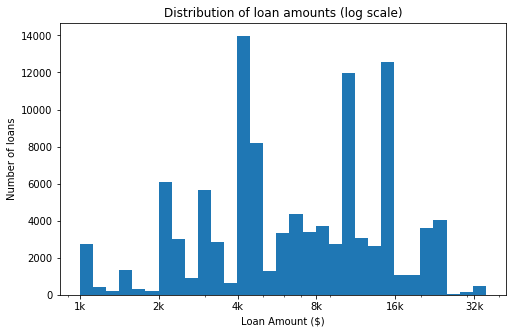

In [136]:
log_binsize = 0.05
bins = 10 ** np.arange(3, np.log10(loans.Amount.max())+log_binsize, log_binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'Amount', bins = bins)
plt.xscale('log')
ticks1,ticks2  = [1e3,2e3,4e3,8e3,16e3,32e3],['1k', '2k', '4k', '8k', '16k','32k']
plt.title('Distribution of loan amounts (log scale)')
plt.xlabel('Loan Amount ($)')
plt.ylabel('Number of loans')
plt.xticks(ticks1, ticks2);

## Distribution of the Monthly Income
The montly income was plotted on the logarithmic scale since there are outliers with untypically high income. However the most common monthly income value is around $5000 which corresponds to the "middle-class" income.

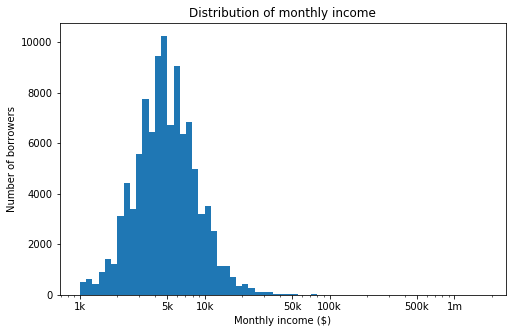

In [60]:
log_binsize = 0.05
bins = 10 ** np.arange(3, np.log10(loans.Income.max())+log_binsize, log_binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'Income', bins = bins)
plt.xscale('log')
ticks1,ticks2 = [1e3,5e3,1e4,5e4,1e5,5e5,1e6],['1k', '5k', '10k', '50k', '100k','500k','1m']
plt.xticks(ticks1, ticks2)
plt.title('Distribution of monthly income')
plt.xlabel('Monthly income ($)')
plt.ylabel('Number of borrowers');

## Distribution by owning a home, the Employment Status and the Occupation
We can see from the distributions that the homeowners and those who don't have a home are roughly in equal proportion and the vast majority of the borrowers are employed. However, later in the analysis I'll look closer on other employment statuses too. We can also see that the most common occupation among those that were specified by borrowers are office-related occupations. 

In [42]:
base_color = sb.color_palette()[0]

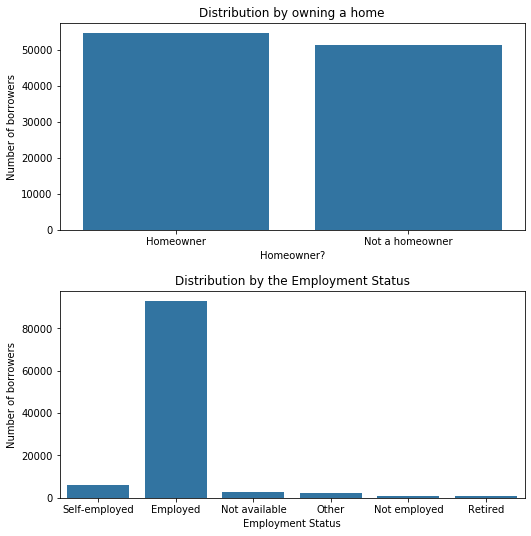

In [61]:
fig, ax = plt.subplots(2,1, figsize = (8,8))
fig.tight_layout(pad=4.0)

home = sb.countplot(data = loans, x = 'Homeowner', color = base_color,ax = ax[0])
home.set_title('Distribution by owning a home')
home.set_xlabel('Homeowner?')
home.set_ylabel('Number of borrowers');

empl = sb.countplot(data = loans, x = 'EmploymentStatus', color = base_color,ax = ax[1])
empl.set_title('Distribution by the Employment Status')
empl.set_xlabel('Employment Status')
empl.set_ylabel('Number of borrowers');

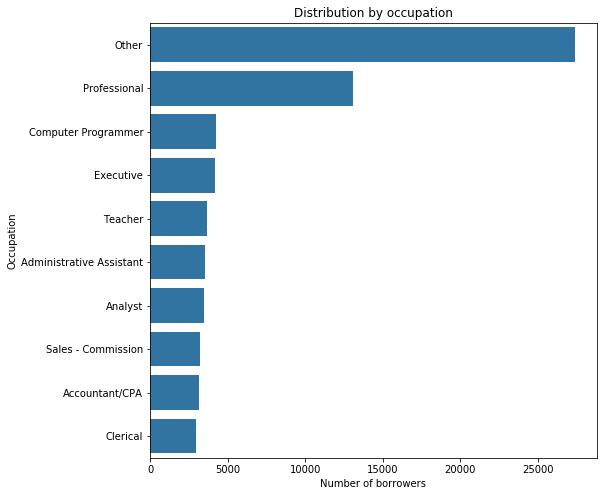

In [62]:
fig, ax = plt.subplots(1,1,figsize = (8,8))

order = loans['Occupation'].value_counts().iloc[:10].index
occup = sb.countplot(data = loans, y = 'Occupation', color = base_color,order=order)
occup.set_title('Distribution by occupation')
occup.set_xlabel('Number of borrowers')
occup.set_ylabel('Occupation');

## Distribution by the Term, Loan Completion Status and the Reason for getting a loan
The distributions show that the most popular term is the 36-month term, the most common reason is a debt consolidation and the vast majority of loans are neither defaulted nor delayed. All of that might indicate that Prosper offers better loan conditions than other loaners. 

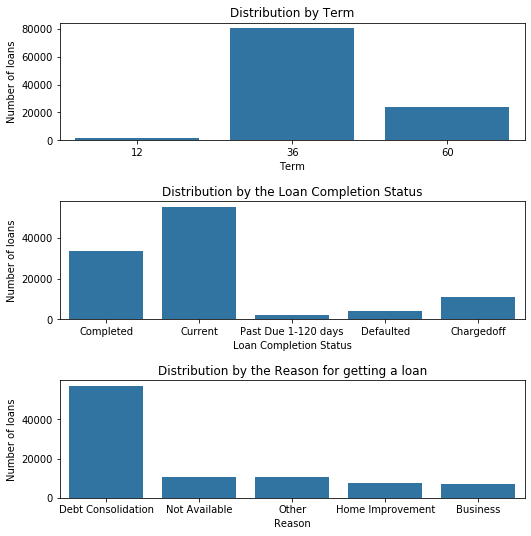

In [63]:
fig, ax = plt.subplots(3,1, figsize = [8,8])
fig.tight_layout(pad=4.0)

order = loans['Category'].value_counts().iloc[:5].index

term = sb.countplot(data = loans, x = 'Term', color = base_color,ax = ax[0])
term.set_title('Distribution by Term')
term.set_ylabel('Number of loans')
term.set_xlabel('Term');

completion = sb.countplot(data = loans, x = 'Status', color = base_color,ax = ax[1])
completion.set_title('Distribution by the Loan Completion Status')
completion.set_ylabel('Number of loans')
completion.set_xlabel('Loan Completion Status');

reason = sb.countplot(data = loans, x = 'Category', color = base_color, order = order, ax=ax[2])
reason.set_title('Distribution by the Reason for getting a loan')
reason.set_ylabel('Number of loans')
reason.set_xlabel('Reason');

## Percentage of Completion Status across the Term and Prosper Score values across the Employment status 

The distribution of Completion Status across the Term shows that the 36-month term has the highest proportion of defaulted and delayed loans which might be due do the high popularity of 36-month term. The other interesting observation - the vast majority of the 12-month term loans are completed and the vast majority of the 60-month term loans are current which makes sence since 60-month loan takes more time to complete. We can also see that Prosper Score is distributed almost symmetrical but retired and employed borrowers have higher proportion of 10 and 11 scores than borrowers in other Employment Statuses.

In [69]:
%%capture
with_score = loans[loans.ProsperScore >0] # we're interested only in scores that available
ordinal = np.arange(1,12,1)
categ = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal)
with_score.ProsperScore = with_score.ProsperScore.astype(categ)

In [70]:
def perc_group(data,grp1,grp2):
    """groups data by the first (grp1) and the second (grp2) grouping values in a selected dataframe (data)"""
    grp = data.groupby([grp1,grp2])['Key'].count().reset_index()
    df = pd.DataFrame({grp1:grp[grp1],grp2:grp[grp2],'Key':grp.Key})
    df['prop'] = df.Key/[df[df[grp1] == i]['Key'].sum() for i in df[grp1]]
    df.drop('Key',axis = 1,inplace = True)
    df = df.pivot(index = grp1, columns = grp2, values = 'prop')
    df.columns = df.columns.tolist()
    df[grp1] = df.index.tolist()
    return df

In [73]:
def plot_perc(*args):
    """creates the unlimited number and sequential palete of clustered bar charts for ordered data"""
    pal = sb.light_palette("navy", as_cmap=True)
    fig, ax = plt.subplots(len(args), 1, figsize = (8,8))
    ranges = [np.arange(0,1.1,0.2),np.arange(0,0.31,0.1)]
    fig.tight_layout(pad=4.0)
    for n, arg in enumerate(args):
        bars = arg.plot(x=arg.iloc[:,-1].name, y=arg.iloc[:,:-1].columns.tolist(), kind='bar', cmap=pal,ax=ax[n])
        tick_names = ['{:.0%}'.format(v) for v in ranges[n]]
        bars.set_yticks(ranges[n])
        bars.set_yticklabels(tick_names)
        bars.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        if n == 0:
            bars.set_title('Proportion of the Completion Statuses by the Term')
            bars.set_ylabel('Percentage from the type of the Term')
            bars.set_xlabel('Term')
        else:
            bars.set_title('Proportion of the Prosper Score value by the Employment Status')
            bars.set_ylabel('Percentage from the type of the Employment Status')
            bars.set_xlabel('Employment Status');

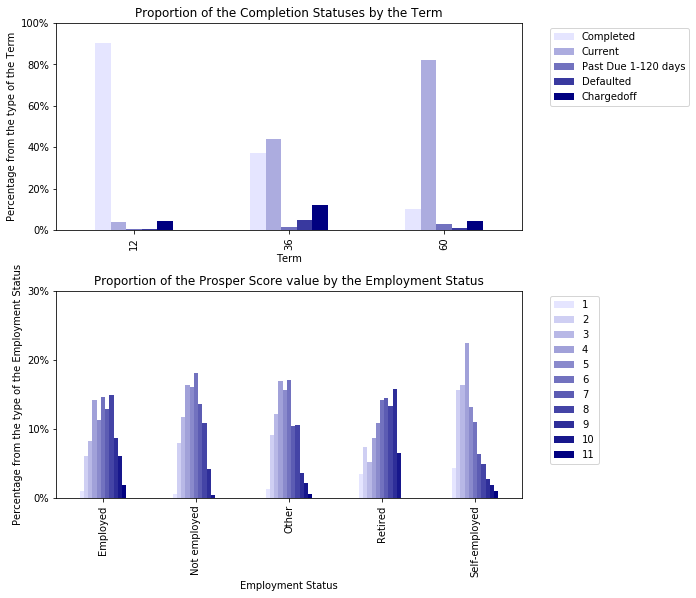

In [74]:
term_grp, emp_grp = perc_group(loans,'Term','Status'), perc_group(with_score,'EmploymentStatus','ProsperScore')
plot_perc(term_grp, emp_grp)

## Credit Score vs. Loan Amount,  Credit Score vs. APR and Loan Amount with APR across top-4 completion status

I plotted the loan amount on the logarithmic scale to get almost linear relationship and it can be seen that the amount increases as the Credit Score increases. The opposite is true too - with the increase of the Credit Score the APR decreases. That makes sense since the Credit Score is the main metric determining the financial discipline of a borrower. It can also be seen that the Debt Consolidation has the highest median loan amount and the lowest median APR across the top 4 most common reasons for getting a loan. 

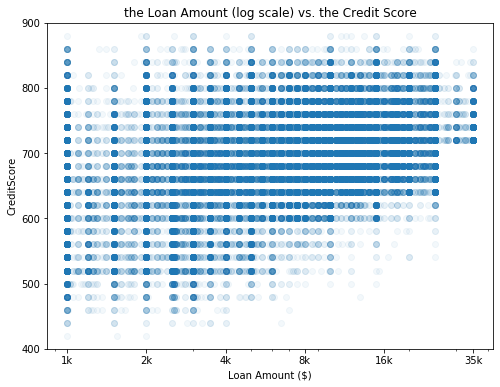

In [84]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans, x = 'Amount', y = 'CreditScore', alpha = 0.05)
plt.title('the Loan Amount (log scale) vs. the Credit Score')
plt.xlabel('Loan Amount ($)')
plt.ylabel('CreditScore')
plt.xscale('log')
plt.xticks([1e3, 2e3, 4e3, 8e3, 16e3, 35e3], ['1k','2k', '4k', '8k', '16k', '35k'])
plt.ylim(400,900);

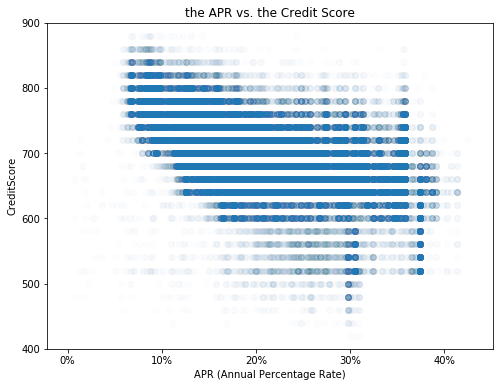

In [124]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans, x = 'APR', y = 'CreditScore', alpha = 0.01)
plt.title('the APR vs. the Credit Score')
plt.xlabel('APR (Annual Percentage Rate)')
plt.ylabel('CreditScore')
plt.ylim(400,900)
apr_ticks = ['{:.0%}'.format(v) for v in np.arange(0,0.45,0.1)]
plt.xticks(np.arange(0,0.45,0.1),apr_ticks);

In [86]:
# compute the logarithm of price to make multivariate plotting easier
def log_trans(x, inverse = False):
    """ quick function for computing log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

loans['log_amount'] = loans.Amount.apply(log_trans)

In [87]:
%%capture
# selecting the top 4 categories excluding 'Not Available'
top4cat_dist = loans[loans.Category.isin(['Debt Consolidation', 'Other', 'Home Improvement', 'Business'])]
top4cat_dist.Category = top4cat_dist.Category.astype(str)

In [127]:
def viol_plt(data, x):
    """creates violin plots for the loan amount and the APR from specified dataframe (data) and categories(x)"""
    fig, ax = plt.subplots(1,2, figsize = [6,6])
    fig.tight_layout(pad=2.0)
    
    x1 = sb.violinplot(data = data, x = x, y = 'log_amount', ax = ax[0], color = base_color,inner='quartile')
    x1.set_title('Distribution of the Loan Amount and the APR across the Reason for getting a loan')
    x1.set_ylabel('Loan Amount ($)')
    x1.set_xlabel('Reason')
    
    y1 = sb.violinplot(data = data, x = x, y = 'APR', ax = ax[1], color = base_color,inner='quartile')
    y1.set_ylabel('APR (Annual Percentage Rate)')
    y1.set_xlabel('Reason')
    y1.set_yticks(np.arange(0,0.45,0.1))
    y1.set_yticklabels(apr_ticks)
    
    
    for x,y in zip(x1.get_xticklabels(),y1.get_xticklabels()):
        x.set_rotation(90),y.set_rotation(90)
    ax[0].set_yticks(log_trans(np.array([1e3, 2e3, 4e3, 8e3, 16e3, 35e3])))
    ax[0].set_yticklabels(['1k','2k', '4k', '8k', '16k', '35k']);

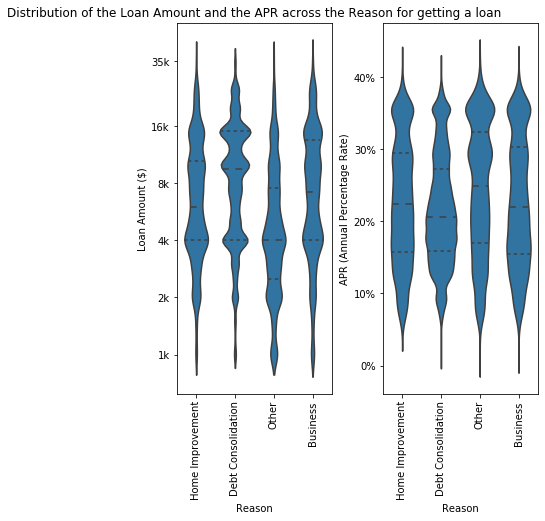

In [128]:
viol_plt(top4cat_dist, 'Category')

## The impact of the Prosper Score on the Loan Amount and on the APR

Point plots clearly show that the higher the Prosper Score the higher the loan amount and the lower APR even though some exceptions from this rule can be observed for the loan amount.

In [52]:
def hist2dgrid(x, y, **kwargs):
    """ Quick hack for creating heat maps with seaborn's PairGrid. """
    palette = kwargs.pop('color')
    bins_x = np.arange(loans.APR.min(), loans.APR.max()+.01, .02)
    bins_y = np.arange(400, 900, 20)
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 1)

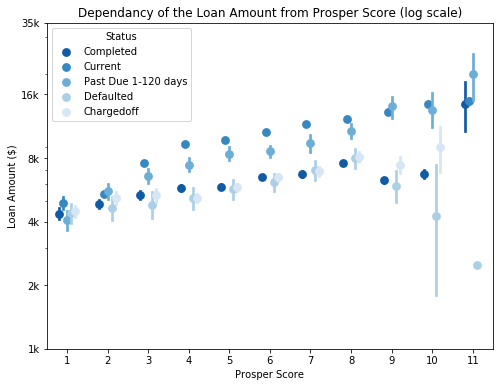

In [133]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = with_score, x = 'ProsperScore', y = 'Amount', hue = 'Status',
           palette = 'Blues_r', linestyles = '', dodge = 0.4)
plt.title('Dependancy of the Loan Amount from Prosper Score (log scale)')
plt.yscale('log')
plt.yticks([1e3, 2e3, 4e3, 8e3, 16e3, 35e3], ['1k','2k', '4k', '8k', '16k', '35k']);
plt.ylabel('Loan Amount ($)')
plt.xlabel('Prosper Score');

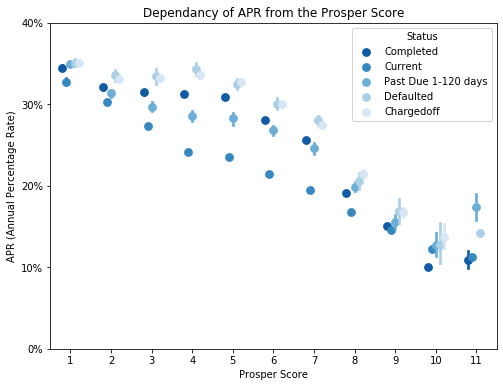

In [135]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = with_score, x = 'ProsperScore', y = 'APR', hue = 'Status',
           palette = 'Blues_r', linestyles = '', dodge = 0.4)
plt.title('Dependancy of APR from the Prosper Score')
plt.ylabel('APR (Annual Percentage Rate)')
plt.yticks(np.arange(0,0.45,0.1),apr_ticks)
plt.xlabel('Prosper Score');

## The Conclusion

### Question 1: The characteristics of an "average" borrower

The "average" borrower earns $5000 month,is employed, work in office, prefers 36-month loan which is used for a debt consolidation and takes different loan amounts. This indicates that the "average" borrower belongs to the "middle-class" and the fact that Prosper Loans might have better conditions for getting a loan for closing other debts. It's also interesting that retired borrowers have the highest proportion of high Prosper Score values which might indicate that they have a better financial discipline and are offered better loan conditions.


### Question 2: What variables impact the loan amount and the APR the most

The Loan Amount and the APR are most affected by the Credit Score which is the main metrics for financial discipline of a borrower. Other variables like the number of delinquencies and the number of credit lines have an impact on the credit score so the credit score value covers them.The other variable which has affects the loan amount and the APR is Prosper score though it's not clear how it is calculated. It was interesting to see that neither income nor the fact of owning a home doesn't seem to correlate with the loan amount and the APR.